## Project Overview

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import cv2
import csv
import time
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from tqdm.notebook import tqdm
import torchvision.transforms.functional as TF


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
class config:
    batchsize = 8
    num_epochs = 50
    learning_rate = 1e-4
    num_classes = 4

In [13]:
pd.set_option('future.no_silent_downcasting', True)

## Data Loading, Labels, and Splits

In [14]:
dataset_path  = "./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/data/BACH/ICIAR2018_BACH_Challenge/Photos"
csv_path      = "./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/data/BACH/ICIAR2018_BACH_Challenge/Photos/microscopy_ground_truth.csv"

In [15]:
df = pd.read_csv(csv_path)
image_paths, labels = [], []

for class_name in ["Benign", "InSitu", "Invasive", "Normal"]:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        if img_name.endswith(".tif"):
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(class_name)


image_df = pd.DataFrame({"image_path": image_paths, "label": labels})

image_df["label"] = image_df["label"].replace({"Normal": 0, "Benign": 1, "InSitu": 2, "Invasive": 3}).astype("int64")
image_df = image_df.sample(frac=1, random_state=42).reset_index(drop=True)
image_df.to_csv("bach_training_data.csv", index=False)

dataset = pd.read_csv("bach_training_data.csv")
dataset.head()

,image_path,label
0,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,3
1,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,3
2,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,1
3,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,3
4,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,1


## Preprocessing, Augmentation, and DataLoaders

This section defines image preprocessing steps such as resizing, normalization, and optional augmentation. The processed data is wrapped into PyTorch `Dataset` and `DataLoader` objects so that images can be efficiently batched, shuffled, and fed into the model during training and evaluation.


In [16]:
class BACHDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        label = torch.tensor(self.data.iloc[idx]["label"], dtype=torch.long)
        image = Image.open(img_path).convert("RGB")
        image = cv2.resize(np.array(image), (224, 224), interpolation=cv2.INTER_AREA)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label

class MinMaxScalerTransform:
    def __call__(self, img):
        img_array = np.array(img).astype(np.float32) / 255.0
        return torch.tensor(img_array).permute(2, 0, 1)

data_transforms = transforms.Compose([
    MinMaxScalerTransform(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

In [17]:
train, temp = train_test_split(dataset, test_size=0.2, stratify=dataset["label"], random_state=42)
val, test = train_test_split(temp, test_size=0.25, stratify=temp["label"], random_state=42)

train_dataset = BACHDataset(train, transform=data_transforms)
val_dataset = BACHDataset(val, transform=None)
test_dataset = BACHDataset(test, transform=None)

train_dataloader = DataLoader(train_dataset, batch_size=config.batchsize, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config.batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config.batchsize, shuffle=True)


Train Samples - Total Batches: 40 | Total Samples: 320


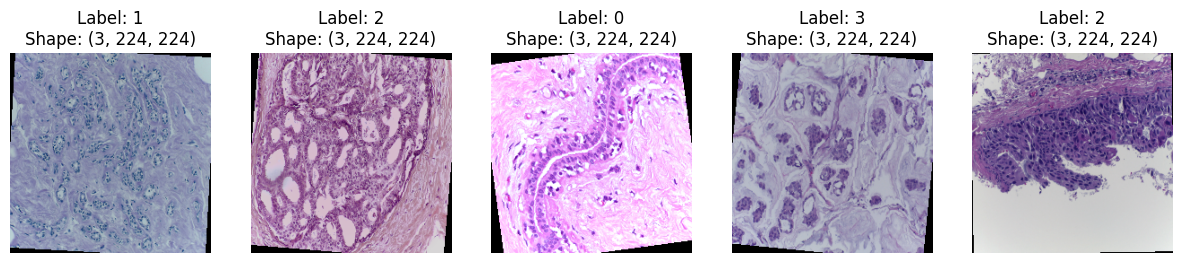


Validation Samples - Total Batches: 8 | Total Samples: 60


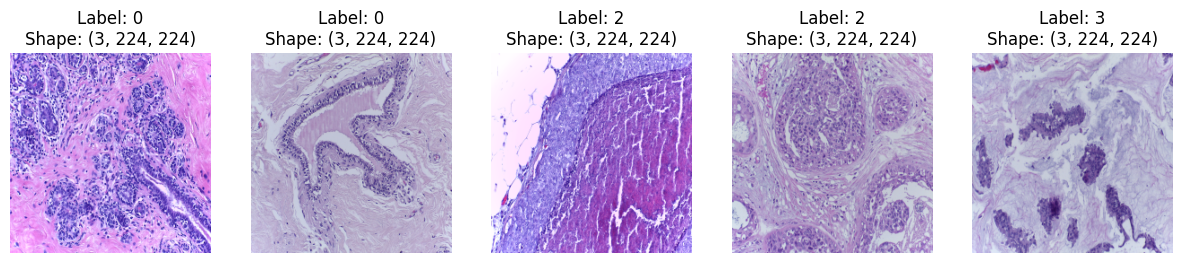


Test Samples - Total Batches: 3 | Total Samples: 20


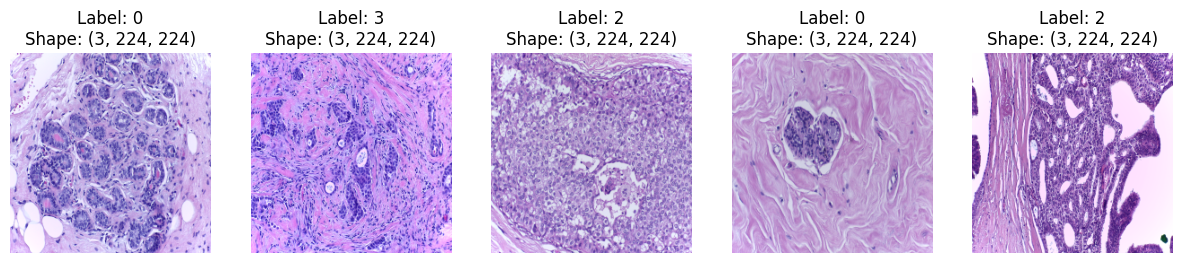

In [18]:
def show_samples(dataloader, title, num_samples=5):
    print(f"\n{title} - Total Batches: {len(dataloader)} | Total Samples: {len(dataloader.dataset)}")


    batch = next(iter(dataloader))

    if isinstance(batch, tuple) and len(batch) == 2:
        images, labels = batch
    elif isinstance(batch, list) and len(batch) == 2:
        images, labels = batch[0], batch[1]
    else:
        raise ValueError(f"Unexpected batch format from DataLoader: {type(batch)}, content: {batch}")


    if isinstance(images, list):
        images = torch.stack(images)


    if images.ndim == 3:
        images = images.unsqueeze(0)

    num_samples = min(num_samples, images.shape[0])


    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]
    for i in range(num_samples):
        img_tensor = images[i]
        img = TF.to_pil_image(img_tensor.cpu())
        label = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        img_shape = tuple(img_tensor.shape)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}\nShape: {img_shape}")
        axes[i].axis("off")



    plt.show()

show_samples(train_dataloader, "Train Samples")
show_samples(val_dataloader, "Validation Samples")
show_samples(test_dataloader, "Test Samples")

## Model Architecture & Training Configuration

Here we define the neural network architecture based on a ResNet backbone with a custom classification head adapted to the four BACH classes. We also specify the loss function, optimizer, learning rate, and other hyperparameters that control how the model learns from the data.


In [19]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)


for param in model.layer1.parameters() :
        param.requires_grad = False
for param in model.layer2.parameters() :
        param.requires_grad = False
for param in model.layer3.parameters() :
        param.requires_grad = False
for param in model.layer4.parameters() :
        param.requires_grad = True
num_features = model.fc.in_features
num_classes = 4


model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)
)


model = model.to(device)


criterion = nn.CrossEntropyLoss()


class_weights = torch.tensor([1.0, 1.5, 1.0, 1.0], dtype=torch.float32).to(device)


criterion_w = nn.CrossEntropyLoss(weight=class_weights)


optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=1e-4)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)

In [20]:
import torch
import torch.nn.functional as F

def convert_to_one_hot(label, num_classes):


    return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)

def compute_multiclass_metrics(preds_list, labels_list, num_classes):

    # Initialize per-class metric accumulators
    TP_per_class = torch.zeros(num_classes)
    TN_per_class = torch.zeros(num_classes)
    FP_per_class = torch.zeros(num_classes)
    FN_per_class = torch.zeros(num_classes)

    correct = 0
    total = len(labels_list)

    for preds, label in zip(preds_list, labels_list):

        label_one_hot = convert_to_one_hot(label, num_classes)


        pred_class = torch.argmax(preds)
        pred_one_hot = convert_to_one_hot(preds, num_classes)


        if preds == label:
            correct += 1


        for class_idx in range(num_classes):

            TP_per_class[class_idx] += int((pred_one_hot[class_idx] == 1) and (label_one_hot[class_idx] == 1))

            TN_per_class[class_idx] += int((pred_one_hot[class_idx] == 0) and (label_one_hot[class_idx] == 0))

            FP_per_class[class_idx] += int((pred_one_hot[class_idx] == 1) and (label_one_hot[class_idx] == 0))

            FN_per_class[class_idx] += int((pred_one_hot[class_idx] == 0) and (label_one_hot[class_idx] == 1))


    precision_per_class = TP_per_class / (TP_per_class + FP_per_class).clamp(min=1e-10)

    recall_per_class = TP_per_class / (TP_per_class + FN_per_class).clamp(min=1e-10)

    specificity_per_class = TN_per_class / (TN_per_class + FP_per_class).clamp(min=1e-10)

    f1_score_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class).clamp(min=1e-10)



    macro_precision = precision_per_class.mean().item()
    macro_recall = recall_per_class.mean().item()
    macro_specificity = specificity_per_class.mean().item()
    macro_f1_score = f1_score_per_class.mean().item()


    accuracy = correct / total

    return {
        "accuracy": accuracy,
        "precision_per_class": precision_per_class.tolist(),
        "macro_precision": macro_precision,
        "recall_per_class": recall_per_class.tolist(),
        "macro_recall": macro_recall,
        "specificity_per_class": specificity_per_class.tolist(),
        "macro_specificity": macro_specificity,
        "f1_score_per_class": f1_score_per_class.tolist(),
        "macro_f1_score": macro_f1_score
    }

In [21]:
def plot_loss(train_losses, val_losses, num_epochs):
    """Plots training and validation loss curves."""
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', linestyle='-')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s', linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


## Model Training & Validation

This section implements the training and validation loops. Across multiple epochs, the model is updated using the training set while performance on the validation set is monitored using metrics such as loss, accuracy, and F1-score to detect underfitting or overfitting.


In [22]:
def train_model(model, optimizer, criterion, train_dataloader, val_dataloader, num_epochs, device, num_classes, model_path, csv_name):

    log_fields = ["epoch", "time", "train_loss", "val_loss", "train_precision", "val_precision",
              "train_recall", "val_recall", "train_F1_Score", "val_F1_Score"]
    total_training_time = 0
    best_val_F1_Score = 0

    train_losses = []
    val_losses = []

    with open(csv_name, 'w', newline='', encoding='utf-8') as csvfile:
         writer = csv.DictWriter(csvfile, fieldnames=log_fields)
         writer.writeheader()

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()

        total_loss = 0
        correct = 0
        total = 0

        all_preds = []
        all_labels = []



        train_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")

        for images, labels in train_iterator:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = F.softmax(outputs, dim=1)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)


            all_preds.append(preds.detach().cpu())
            all_labels.append(labels.detach().cpu())

            train_iterator.set_postfix(loss=f"{loss:.4f}")

        epoch_time = time.time() - start_time
        total_training_time += epoch_time
        accuracy = correct / total


        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)


        metrics = compute_multiclass_metrics(all_preds, all_labels, num_classes)

        epoch_train_loss = total_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)


        # Print metrics for each class
        print(f"Epoch {epoch + 1} - Loss: {epoch_train_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {epoch_time:.2f}s")
        print(f"Macro Precision: {metrics['macro_precision']:.4f}, Macro Recall: {metrics['macro_recall']:.4f}, Macro F1-score: {metrics['macro_f1_score']:.4f}")

        for class_idx in range(num_classes):
            print(f"Class {class_idx} - Precision: {metrics['precision_per_class'][class_idx]:.4f}, Recall: {metrics['recall_per_class'][class_idx]:.4f}, F1-score: {metrics['f1_score_per_class'][class_idx]:.4f}")

        all_val_preds,all_val_labels,val_accuracy, val_loss = valid_model(model,criterion, val_dataloader, device, epoch, num_classes)
        val_metrics = compute_multiclass_metrics(all_val_preds, all_val_labels, num_classes)
        val_losses.append(val_loss)
        print("Validation_Metrics")
        print(f"Epoch {epoch + 1} - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
        print(f"Macro Precision: {val_metrics['macro_precision']:.4f}, Macro Recall: {val_metrics['macro_recall']:.4f}, Macro F1-score: {val_metrics['macro_f1_score']:.4f}")

        for class_idx in range(num_classes):
            print(f"Class {class_idx} - Precision: {val_metrics['precision_per_class'][class_idx]:.4f}, Recall: {val_metrics['recall_per_class'][class_idx]:.4f}, F1-score: {val_metrics['f1_score_per_class'][class_idx]:.4f}")

            # Save best model based on Dice score
        if val_metrics['macro_f1_score'] > best_val_F1_Score:
            best_val_F1_Score = val_metrics['macro_f1_score']
            torch.save(model.state_dict(), model_path)
            print(f"Model saved at epoch {epoch+1} with F1_score: {best_val_F1_Score:.4f}")
            # Log training and validation metrics
        with open(csv_name, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=log_fields)
            writer.writerow({
                "epoch": epoch + 1,
                "time": round(epoch_time, 2),
                "train_loss": round(total_loss/len(train_dataloader), 4),
                "val_loss": round(val_loss, 4),
                "train_precision": round(metrics['macro_precision'], 4),
                "val_precision": round(val_metrics['macro_precision'], 4),
                "train_recall": round(metrics['macro_recall'], 4),
                "val_recall": round(val_metrics['macro_recall'], 4),
                "train_F1_Score": round(metrics['macro_f1_score'], 4),
                "val_F1_Score": round(val_metrics['macro_f1_score'], 4),

            })


    print(f"Training Complete in {total_training_time:.4f}s with {total_training_time/num_epochs:.4f}s per epoch with Best_F1_Score {best_val_F1_Score:.4f}.")
    print(f"Best Validation F1 Score: {best_val_F1_Score:.4f}")

    plot_loss(train_losses, val_losses, num_epochs)

In [23]:
def valid_model(model,criterion, dataloader, device, epoch, num_classes):

    all_val_preds = []
    all_val_labels = []
    val_loss = 0
    val_correct = 0
    val_total= 0
    model.eval()

    val_iterator = tqdm(dataloader, desc=f"Epoch {epoch + 1}")

    with torch.no_grad():
            for images,labels  in val_iterator:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = F.softmax(outputs, dim=1)
                preds = torch.argmax(preds, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)


                all_val_preds.append(preds.detach().cpu())
                all_val_labels.append(labels.detach().cpu())

    val_iterator.set_postfix(loss=f"{loss:.4f}")
    val_accuracy = val_correct / val_total
    all_val_preds = torch.cat(all_val_preds, dim=0)
    all_val_labels = torch.cat(all_val_labels, dim=0)
    val_loss /= len(dataloader)
    scheduler.step(val_loss)

    return all_val_preds,all_val_labels,val_accuracy, val_loss


In [24]:
def inference_model(model, model_path, dataloader, device, num_classes):


    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()

    all_preds = []
    all_labels = []

    inference_iterator = tqdm(dataloader, desc="Running Inference")

    start_time = time.time()

    with torch.no_grad():
        for images, labels in inference_iterator:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            preds = F.softmax(outputs, dim=1)
            preds = torch.argmax(preds, dim=1)


            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())


    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)


    metrics = compute_multiclass_metrics(all_preds, all_labels, num_classes)

    # confusion matrix heatmap
    # Convert tensors to numpy arrays
    y_true = all_labels.numpy()
    y_pred = all_preds.numpy()

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Class names must match your label encoding:
    # "Normal": 0, "Benign": 1, "InSitu": 2, "Invasive": 3
    class_names = ["Normal", "Benign", "InSitu", "Invasive"]

    # Plot confusion matrix
    plot_confusion_matrix(
        cm,
        class_names=class_names,
        title="Confusion Matrix - Test Set",

        save_path="confusion_matrix_test.png"  # or None if you don't want to save
    )


    inference_time = time.time() - start_time
    print(f"\nInference Completed in {inference_time:.2f}s")

    print(f"\nMacro Precision: {metrics['macro_precision']:.4f}, Macro Recall: {metrics['macro_recall']:.4f}, Macro F1-score: {metrics['macro_f1_score']:.4f}")

    for class_idx in range(num_classes):
        print(f"Class {class_idx} - Precision: {metrics['precision_per_class'][class_idx]:.4f}, Recall: {metrics['recall_per_class'][class_idx]:.4f}, F1-score: {metrics['f1_score_per_class'][class_idx]:.4f}")




In [25]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", save_path=None):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="gray_r",
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        linecolor=None#'black'
    )
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Confusion matrix saved to: {save_path}")

    plt.show()


Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 - Loss: 1.3766, Accuracy: 0.2938, Time: 388.27s
Macro Precision: 0.2974, Macro Recall: 0.2938, Macro F1-score: 0.2357
Class 0 - Precision: 0.3020, Recall: 0.5625, F1-score: 0.3930
Class 1 - Precision: 0.3750, Recall: 0.0750, F1-score: 0.1250
Class 2 - Precision: 0.2817, Recall: 0.5000, F1-score: 0.3604
Class 3 - Precision: 0.2308, Recall: 0.0375, F1-score: 0.0645


/tmp/ipython-input-324665692.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)


Epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 1 - Loss: 1.3404, Accuracy: 0.2667
Macro Precision: 0.1182, Macro Recall: 0.2667, Macro F1-score: 0.1321
Class 0 - Precision: 0.2727, Recall: 1.0000, F1-score: 0.4286
Class 1 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Class 2 - Precision: 0.2000, Recall: 0.0667, F1-score: 0.1000
Class 3 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Model saved at epoch 1 with F1_score: 0.1321


Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 - Loss: 1.2817, Accuracy: 0.3469, Time: 21.55s
Macro Precision: 0.3825, Macro Recall: 0.3469, Macro F1-score: 0.2646
Class 0 - Precision: 0.3238, Recall: 0.9875, F1-score: 0.4877
Class 1 - Precision: 0.2000, Recall: 0.0125, F1-score: 0.0235
Class 2 - Precision: 0.2979, Recall: 0.1750, F1-score: 0.2205
Class 3 - Precision: 0.7083, Recall: 0.2125, F1-score: 0.3269


Epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 2 - Loss: 1.1518, Accuracy: 0.6833
Macro Precision: 0.7574, Macro Recall: 0.6833, Macro F1-score: 0.6601
Class 0 - Precision: 0.5172, Recall: 1.0000, F1-score: 0.6818
Class 1 - Precision: 0.8000, Recall: 0.2667, F1-score: 0.4000
Class 2 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 3 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Model saved at epoch 2 with F1_score: 0.6601


Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 - Loss: 1.1649, Accuracy: 0.5125, Time: 21.26s
Macro Precision: 0.5297, Macro Recall: 0.5125, Macro F1-score: 0.4501
Class 0 - Precision: 0.4713, Recall: 0.9250, F1-score: 0.6245
Class 1 - Precision: 0.4400, Recall: 0.1375, F1-score: 0.2095
Class 2 - Precision: 0.6538, Recall: 0.2125, F1-score: 0.3208
Class 3 - Precision: 0.5536, Recall: 0.7750, F1-score: 0.6458


Epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 3 - Loss: 1.0503, Accuracy: 0.5667
Macro Precision: 0.6143, Macro Recall: 0.5667, Macro F1-score: 0.5047
Class 0 - Precision: 0.6667, Recall: 0.9333, F1-score: 0.7778
Class 1 - Precision: 0.8571, Recall: 0.4000, F1-score: 0.5455
Class 2 - Precision: 0.5000, Recall: 0.0667, F1-score: 0.1176
Class 3 - Precision: 0.4333, Recall: 0.8667, F1-score: 0.5778


Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 - Loss: 1.0117, Accuracy: 0.5594, Time: 21.07s
Macro Precision: 0.5335, Macro Recall: 0.5594, Macro F1-score: 0.5030
Class 0 - Precision: 0.6514, Recall: 0.8875, F1-score: 0.7513
Class 1 - Precision: 0.5294, Recall: 0.3375, F1-score: 0.4122
Class 2 - Precision: 0.4348, Recall: 0.1250, F1-score: 0.1942
Class 3 - Precision: 0.5182, Recall: 0.8875, F1-score: 0.6544


Epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 4 - Loss: 0.9626, Accuracy: 0.7167
Macro Precision: 0.7247, Macro Recall: 0.7167, Macro F1-score: 0.7147
Class 0 - Precision: 0.7222, Recall: 0.8667, F1-score: 0.7879
Class 1 - Precision: 0.6250, Recall: 0.6667, F1-score: 0.6452
Class 2 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 3 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Model saved at epoch 4 with F1_score: 0.7147


Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 - Loss: 0.8426, Accuracy: 0.6625, Time: 21.01s
Macro Precision: 0.6710, Macro Recall: 0.6625, Macro F1-score: 0.6555
Class 0 - Precision: 0.8148, Recall: 0.8250, F1-score: 0.8199
Class 1 - Precision: 0.4719, Recall: 0.5250, F1-score: 0.4970
Class 2 - Precision: 0.7143, Recall: 0.4375, F1-score: 0.5426
Class 3 - Precision: 0.6832, Recall: 0.8625, F1-score: 0.7624


Epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 5 - Loss: 0.9061, Accuracy: 0.7833
Macro Precision: 0.7864, Macro Recall: 0.7833, Macro F1-score: 0.7836
Class 0 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Model saved at epoch 5 with F1_score: 0.7836


Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6 - Loss: 0.6725, Accuracy: 0.7000, Time: 21.01s
Macro Precision: 0.6892, Macro Recall: 0.7000, Macro F1-score: 0.6934
Class 0 - Precision: 0.7927, Recall: 0.8125, F1-score: 0.8025
Class 1 - Precision: 0.4857, Recall: 0.4250, F1-score: 0.4533
Class 2 - Precision: 0.6582, Recall: 0.6500, F1-score: 0.6541
Class 3 - Precision: 0.8202, Recall: 0.9125, F1-score: 0.8639


Epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 6 - Loss: 0.6650, Accuracy: 0.7667
Macro Precision: 0.7598, Macro Recall: 0.7667, Macro F1-score: 0.7572
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6364, Recall: 0.4667, F1-score: 0.5385
Class 2 - Precision: 0.7222, Recall: 0.8667, F1-score: 0.7879
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7 - Loss: 0.5510, Accuracy: 0.7750, Time: 20.80s
Macro Precision: 0.7719, Macro Recall: 0.7750, Macro F1-score: 0.7725
Class 0 - Precision: 0.8354, Recall: 0.8250, F1-score: 0.8302
Class 1 - Precision: 0.6667, Recall: 0.6000, F1-score: 0.6316
Class 2 - Precision: 0.7901, Recall: 0.8000, F1-score: 0.7950
Class 3 - Precision: 0.7955, Recall: 0.8750, F1-score: 0.8333


Epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 7 - Loss: 0.6643, Accuracy: 0.7500
Macro Precision: 0.7519, Macro Recall: 0.7500, Macro F1-score: 0.7497
Class 0 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 1 - Precision: 0.6000, Recall: 0.6000, F1-score: 0.6000
Class 2 - Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8 - Loss: 0.4881, Accuracy: 0.8063, Time: 20.61s
Macro Precision: 0.8038, Macro Recall: 0.8063, Macro F1-score: 0.8039
Class 0 - Precision: 0.8500, Recall: 0.8500, F1-score: 0.8500
Class 1 - Precision: 0.6761, Recall: 0.6000, F1-score: 0.6358
Class 2 - Precision: 0.7640, Recall: 0.8500, F1-score: 0.8047
Class 3 - Precision: 0.9250, Recall: 0.9250, F1-score: 0.9250


Epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 8 - Loss: 0.7302, Accuracy: 0.7167
Macro Precision: 0.7266, Macro Recall: 0.7167, Macro F1-score: 0.7202
Class 0 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 1 - Precision: 0.5000, Recall: 0.5333, F1-score: 0.5161
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9 - Loss: 0.3902, Accuracy: 0.8688, Time: 20.58s
Macro Precision: 0.8671, Macro Recall: 0.8687, Macro F1-score: 0.8672
Class 0 - Precision: 0.8537, Recall: 0.8750, F1-score: 0.8642
Class 1 - Precision: 0.8194, Recall: 0.7375, F1-score: 0.7763
Class 2 - Precision: 0.8675, Recall: 0.9000, F1-score: 0.8834
Class 3 - Precision: 0.9277, Recall: 0.9625, F1-score: 0.9448


Epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 9 - Loss: 0.7336, Accuracy: 0.7833
Macro Precision: 0.7908, Macro Recall: 0.7833, Macro F1-score: 0.7812
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.7059, Recall: 0.8000, F1-score: 0.7500
Class 2 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 3 - Precision: 0.8462, Recall: 0.7333, F1-score: 0.7857


Epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 - Loss: 0.2994, Accuracy: 0.8906, Time: 20.87s
Macro Precision: 0.8911, Macro Recall: 0.8906, Macro F1-score: 0.8906
Class 0 - Precision: 0.9211, Recall: 0.8750, F1-score: 0.8974
Class 1 - Precision: 0.8148, Recall: 0.8250, F1-score: 0.8199
Class 2 - Precision: 0.9024, Recall: 0.9250, F1-score: 0.9136
Class 3 - Precision: 0.9259, Recall: 0.9375, F1-score: 0.9317


Epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 10 - Loss: 0.6237, Accuracy: 0.7500
Macro Precision: 0.7596, Macro Recall: 0.7500, Macro F1-score: 0.7471
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.5333, F1-score: 0.5926
Class 2 - Precision: 0.6316, Recall: 0.8000, F1-score: 0.7059
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148


Epoch 11:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11 - Loss: 0.3088, Accuracy: 0.8719, Time: 20.99s
Macro Precision: 0.8728, Macro Recall: 0.8719, Macro F1-score: 0.8721
Class 0 - Precision: 0.8947, Recall: 0.8500, F1-score: 0.8718
Class 1 - Precision: 0.7683, Recall: 0.7875, F1-score: 0.7778
Class 2 - Precision: 0.8916, Recall: 0.9250, F1-score: 0.9080
Class 3 - Precision: 0.9367, Recall: 0.9250, F1-score: 0.9308


Epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 11 - Loss: 0.9441, Accuracy: 0.7167
Macro Precision: 0.7169, Macro Recall: 0.7167, Macro F1-score: 0.6963
Class 0 - Precision: 0.6522, Recall: 1.0000, F1-score: 0.7895
Class 1 - Precision: 0.6250, Recall: 0.3333, F1-score: 0.4348
Class 2 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 12:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12 - Loss: 0.2444, Accuracy: 0.9125, Time: 20.95s
Macro Precision: 0.9132, Macro Recall: 0.9125, Macro F1-score: 0.9126
Class 0 - Precision: 0.9351, Recall: 0.9000, F1-score: 0.9172
Class 1 - Precision: 0.8395, Recall: 0.8500, F1-score: 0.8447
Class 2 - Precision: 0.9615, Recall: 0.9375, F1-score: 0.9494
Class 3 - Precision: 0.9167, Recall: 0.9625, F1-score: 0.9390


Epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 12 - Loss: 1.0274, Accuracy: 0.7167
Macro Precision: 0.7223, Macro Recall: 0.7167, Macro F1-score: 0.7056
Class 0 - Precision: 0.6667, Recall: 0.9333, F1-score: 0.7778
Class 1 - Precision: 0.6000, Recall: 0.4000, F1-score: 0.4800
Class 2 - Precision: 0.7059, Recall: 0.8000, F1-score: 0.7500
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148


Epoch 13:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13 - Loss: 0.1780, Accuracy: 0.9281, Time: 20.99s
Macro Precision: 0.9282, Macro Recall: 0.9281, Macro F1-score: 0.9281
Class 0 - Precision: 0.9231, Recall: 0.9000, F1-score: 0.9114
Class 1 - Precision: 0.8642, Recall: 0.8750, F1-score: 0.8696
Class 2 - Precision: 0.9506, Recall: 0.9625, F1-score: 0.9565
Class 3 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750


Epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 13 - Loss: 0.8253, Accuracy: 0.7500
Macro Precision: 0.7756, Macro Recall: 0.7500, Macro F1-score: 0.7476
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.7273, Recall: 0.5333, F1-score: 0.6154
Class 2 - Precision: 0.5909, Recall: 0.8667, F1-score: 0.7027
Class 3 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692


Epoch 14:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14 - Loss: 0.2001, Accuracy: 0.9344, Time: 21.23s
Macro Precision: 0.9341, Macro Recall: 0.9344, Macro F1-score: 0.9342
Class 0 - Precision: 0.9367, Recall: 0.9250, F1-score: 0.9308
Class 1 - Precision: 0.8861, Recall: 0.8750, F1-score: 0.8805
Class 2 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 3 - Precision: 0.9512, Recall: 0.9750, F1-score: 0.9630


Epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 14 - Loss: 1.0993, Accuracy: 0.7167
Macro Precision: 0.7256, Macro Recall: 0.7167, Macro F1-score: 0.7045
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7500, Recall: 0.4000, F1-score: 0.5217
Class 2 - Precision: 0.5789, Recall: 0.7333, F1-score: 0.6471
Class 3 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742


Epoch 15:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15 - Loss: 0.1417, Accuracy: 0.9531, Time: 20.93s
Macro Precision: 0.9532, Macro Recall: 0.9531, Macro F1-score: 0.9530
Class 0 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 1 - Precision: 0.9241, Recall: 0.9125, F1-score: 0.9182
Class 2 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 3 - Precision: 0.9518, Recall: 0.9875, F1-score: 0.9693


Epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 15 - Loss: 0.8210, Accuracy: 0.8000
Macro Precision: 0.8102, Macro Recall: 0.8000, Macro F1-score: 0.7927
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8000, Recall: 0.5333, F1-score: 0.6400
Class 2 - Precision: 0.6842, Recall: 0.8667, F1-score: 0.7647
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571
Model saved at epoch 15 with F1_score: 0.7927


Epoch 16:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16 - Loss: 0.1273, Accuracy: 0.9656, Time: 21.10s
Macro Precision: 0.9663, Macro Recall: 0.9656, Macro F1-score: 0.9659
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9157, Recall: 0.9500, F1-score: 0.9325
Class 2 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 3 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750


Epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 16 - Loss: 1.0772, Accuracy: 0.7833
Macro Precision: 0.7833, Macro Recall: 0.7833, Macro F1-score: 0.7744
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8000, Recall: 0.5333, F1-score: 0.6400
Class 2 - Precision: 0.6875, Recall: 0.7333, F1-score: 0.7097
Class 3 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387


Epoch 17:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17 - Loss: 0.1225, Accuracy: 0.9625, Time: 20.87s
Macro Precision: 0.9626, Macro Recall: 0.9625, Macro F1-score: 0.9624
Class 0 - Precision: 0.9740, Recall: 0.9375, F1-score: 0.9554
Class 1 - Precision: 0.9259, Recall: 0.9375, F1-score: 0.9317
Class 2 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 3 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877


Epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 17 - Loss: 0.7705, Accuracy: 0.8333
Macro Precision: 0.8362, Macro Recall: 0.8333, Macro F1-score: 0.8276
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Model saved at epoch 17 with F1_score: 0.8276


Epoch 18:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18 - Loss: 0.0736, Accuracy: 0.9812, Time: 21.08s
Macro Precision: 0.9812, Macro Recall: 0.9812, Macro F1-score: 0.9812
Class 0 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 1 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 18 - Loss: 0.7824, Accuracy: 0.8167
Macro Precision: 0.8170, Macro Recall: 0.8167, Macro F1-score: 0.8106
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 2 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 3 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667


Epoch 19:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19 - Loss: 0.0751, Accuracy: 0.9719, Time: 21.26s
Macro Precision: 0.9718, Macro Recall: 0.9719, Macro F1-score: 0.9718
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 0.9620, Recall: 0.9500, F1-score: 0.9560
Class 2 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 3 - Precision: 0.9630, Recall: 0.9750, F1-score: 0.9689


Epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 19 - Loss: 0.8902, Accuracy: 0.8333
Macro Precision: 0.8362, Macro Recall: 0.8333, Macro F1-score: 0.8276
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966


Epoch 20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20 - Loss: 0.0598, Accuracy: 0.9875, Time: 20.95s
Macro Precision: 0.9876, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877


Epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 20 - Loss: 0.7191, Accuracy: 0.8167
Macro Precision: 0.8167, Macro Recall: 0.8167, Macro F1-score: 0.8127
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7500, Recall: 0.6000, F1-score: 0.6667
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966


Epoch 21:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21 - Loss: 0.0451, Accuracy: 0.9938, Time: 21.19s
Macro Precision: 0.9937, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 21 - Loss: 0.9123, Accuracy: 0.8000
Macro Precision: 0.8004, Macro Recall: 0.8000, Macro F1-score: 0.7937
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7273, Recall: 0.5333, F1-score: 0.6154
Class 2 - Precision: 0.7222, Recall: 0.8667, F1-score: 0.7879
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966


Epoch 22:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22 - Loss: 0.0688, Accuracy: 0.9812, Time: 20.75s
Macro Precision: 0.9812, Macro Recall: 0.9812, Macro F1-score: 0.9812
Class 0 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 1 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 22 - Loss: 0.8060, Accuracy: 0.8000
Macro Precision: 0.8123, Macro Recall: 0.8000, Macro F1-score: 0.8013
Class 0 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Class 1 - Precision: 0.7143, Recall: 0.6667, F1-score: 0.6897
Class 2 - Precision: 0.7222, Recall: 0.8667, F1-score: 0.7879
Class 3 - Precision: 1.0000, Recall: 0.8000, F1-score: 0.8889


Epoch 23:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23 - Loss: 0.0456, Accuracy: 0.9844, Time: 20.83s
Macro Precision: 0.9843, Macro Recall: 0.9844, Macro F1-score: 0.9843
Class 0 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 1 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 23 - Loss: 0.8111, Accuracy: 0.8167
Macro Precision: 0.8229, Macro Recall: 0.8167, Macro F1-score: 0.8174
Class 0 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Class 1 - Precision: 0.7143, Recall: 0.6667, F1-score: 0.6897
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 24:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24 - Loss: 0.0481, Accuracy: 0.9906, Time: 21.02s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 24 - Loss: 0.9343, Accuracy: 0.8667
Macro Precision: 0.8730, Macro Recall: 0.8667, Macro F1-score: 0.8655
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8462, Recall: 0.7333, F1-score: 0.7857
Class 2 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286
Model saved at epoch 24 with F1_score: 0.8655


Epoch 25:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25 - Loss: 0.0512, Accuracy: 0.9781, Time: 21.42s
Macro Precision: 0.9782, Macro Recall: 0.9781, Macro F1-score: 0.9781
Class 0 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 1 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814


Epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 25 - Loss: 0.8447, Accuracy: 0.8500
Macro Precision: 0.8579, Macro Recall: 0.8500, Macro F1-score: 0.8488
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Class 2 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Class 3 - Precision: 1.0000, Recall: 0.8000, F1-score: 0.8889


Epoch 26:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26 - Loss: 0.0753, Accuracy: 0.9875, Time: 21.33s
Macro Precision: 0.9878, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 2 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 3 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873


Epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 26 - Loss: 0.9219, Accuracy: 0.8333
Macro Precision: 0.8434, Macro Recall: 0.8333, Macro F1-score: 0.8295
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 2 - Precision: 0.7222, Recall: 0.8667, F1-score: 0.7879
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 27:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27 - Loss: 0.0413, Accuracy: 0.9969, Time: 21.12s
Macro Precision: 0.9969, Macro Recall: 0.9969, Macro F1-score: 0.9969
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 27 - Loss: 1.0118, Accuracy: 0.8500
Macro Precision: 0.8578, Macro Recall: 0.8500, Macro F1-score: 0.8477
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 28:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28 - Loss: 0.0617, Accuracy: 0.9781, Time: 20.91s
Macro Precision: 0.9783, Macro Recall: 0.9781, Macro F1-score: 0.9782
Class 0 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 1 - Precision: 0.9506, Recall: 0.9625, F1-score: 0.9565
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 28 - Loss: 0.7476, Accuracy: 0.8667
Macro Precision: 0.8730, Macro Recall: 0.8667, Macro F1-score: 0.8655
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8462, Recall: 0.7333, F1-score: 0.7857
Class 2 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 29:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29 - Loss: 0.0312, Accuracy: 0.9875, Time: 21.02s
Macro Precision: 0.9875, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 1 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 29 - Loss: 1.0826, Accuracy: 0.8333
Macro Precision: 0.8544, Macro Recall: 0.8333, Macro F1-score: 0.8306
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.6842, Recall: 0.8667, F1-score: 0.7647
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 30:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30 - Loss: 0.0307, Accuracy: 0.9938, Time: 21.28s
Macro Precision: 0.9939, Macro Recall: 0.9937, Macro F1-score: 0.9938
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877


Epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 30 - Loss: 0.8164, Accuracy: 0.8333
Macro Precision: 0.8434, Macro Recall: 0.8333, Macro F1-score: 0.8295
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 2 - Precision: 0.7222, Recall: 0.8667, F1-score: 0.7879
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 31:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31 - Loss: 0.0341, Accuracy: 0.9875, Time: 20.85s
Macro Precision: 0.9878, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9639, Recall: 1.0000, F1-score: 0.9816
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 1.0000, Recall: 0.9625, F1-score: 0.9809


Epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 31 - Loss: 0.7638, Accuracy: 0.8500
Macro Precision: 0.8578, Macro Recall: 0.8500, Macro F1-score: 0.8477
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 32:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32 - Loss: 0.0359, Accuracy: 0.9938, Time: 20.98s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 32 - Loss: 0.7984, Accuracy: 0.8167
Macro Precision: 0.8167, Macro Recall: 0.8167, Macro F1-score: 0.8127
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7500, Recall: 0.6000, F1-score: 0.6667
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966


Epoch 33:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33 - Loss: 0.0386, Accuracy: 0.9938, Time: 20.96s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 33 - Loss: 0.7972, Accuracy: 0.8500
Macro Precision: 0.8520, Macro Recall: 0.8500, Macro F1-score: 0.8478
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8462, Recall: 0.7333, F1-score: 0.7857
Class 2 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966


Epoch 34:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34 - Loss: 0.0200, Accuracy: 0.9969, Time: 20.89s
Macro Precision: 0.9969, Macro Recall: 0.9969, Macro F1-score: 0.9969
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 34 - Loss: 0.9394, Accuracy: 0.8500
Macro Precision: 0.8578, Macro Recall: 0.8500, Macro F1-score: 0.8477
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 35:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35 - Loss: 0.0614, Accuracy: 0.9750, Time: 21.29s
Macro Precision: 0.9755, Macro Recall: 0.9750, Macro F1-score: 0.9751
Class 0 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 1 - Precision: 0.9512, Recall: 0.9750, F1-score: 0.9630
Class 2 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 3 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753


Epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 35 - Loss: 0.7648, Accuracy: 0.8500
Macro Precision: 0.8578, Macro Recall: 0.8500, Macro F1-score: 0.8477
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 36:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36 - Loss: 0.0226, Accuracy: 0.9969, Time: 21.30s
Macro Precision: 0.9969, Macro Recall: 0.9969, Macro F1-score: 0.9969
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 36 - Loss: 0.9971, Accuracy: 0.8333
Macro Precision: 0.8362, Macro Recall: 0.8333, Macro F1-score: 0.8276
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966


Epoch 37:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37 - Loss: 0.0496, Accuracy: 0.9875, Time: 21.23s
Macro Precision: 0.9875, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811


Epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 37 - Loss: 0.8469, Accuracy: 0.8333
Macro Precision: 0.8362, Macro Recall: 0.8333, Macro F1-score: 0.8276
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8182, Recall: 0.6000, F1-score: 0.6923
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966


Epoch 38:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38 - Loss: 0.0312, Accuracy: 0.9938, Time: 21.41s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 38 - Loss: 0.9328, Accuracy: 0.8500
Macro Precision: 0.8578, Macro Recall: 0.8500, Macro F1-score: 0.8477
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 39:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39 - Loss: 0.0368, Accuracy: 0.9906, Time: 21.23s
Macro Precision: 0.9908, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 39 - Loss: 0.8797, Accuracy: 0.8333
Macro Precision: 0.8363, Macro Recall: 0.8333, Macro F1-score: 0.8301
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966


Epoch 40:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40 - Loss: 0.0288, Accuracy: 0.9938, Time: 21.14s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 40 - Loss: 0.8845, Accuracy: 0.8500
Macro Precision: 0.8578, Macro Recall: 0.8500, Macro F1-score: 0.8477
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 41:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41 - Loss: 0.0373, Accuracy: 0.9812, Time: 21.14s
Macro Precision: 0.9815, Macro Recall: 0.9813, Macro F1-score: 0.9812
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 2 - Precision: 0.9639, Recall: 1.0000, F1-score: 0.9816
Class 3 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811


Epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 41 - Loss: 0.9022, Accuracy: 0.8167
Macro Precision: 0.8178, Macro Recall: 0.8167, Macro F1-score: 0.8150
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7692, Recall: 0.6667, F1-score: 0.7143
Class 2 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966


Epoch 42:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42 - Loss: 0.0391, Accuracy: 0.9906, Time: 21.47s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 42 - Loss: 0.8873, Accuracy: 0.8333
Macro Precision: 0.8394, Macro Recall: 0.8333, Macro F1-score: 0.8326
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7692, Recall: 0.6667, F1-score: 0.7143
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 43:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43 - Loss: 0.0341, Accuracy: 0.9938, Time: 21.30s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 43 - Loss: 0.7919, Accuracy: 0.8167
Macro Precision: 0.8167, Macro Recall: 0.8167, Macro F1-score: 0.8127
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7500, Recall: 0.6000, F1-score: 0.6667
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966


Epoch 44:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44 - Loss: 0.0280, Accuracy: 0.9906, Time: 21.36s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 1 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 44 - Loss: 0.9505, Accuracy: 0.8500
Macro Precision: 0.8578, Macro Recall: 0.8500, Macro F1-score: 0.8477
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 45:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45 - Loss: 0.0333, Accuracy: 0.9938, Time: 21.32s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 45 - Loss: 0.9370, Accuracy: 0.8500
Macro Precision: 0.8578, Macro Recall: 0.8500, Macro F1-score: 0.8477
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 46:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46 - Loss: 0.0357, Accuracy: 0.9875, Time: 21.43s
Macro Precision: 0.9877, Macro Recall: 0.9875, Macro F1-score: 0.9876
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 46 - Loss: 0.8117, Accuracy: 0.8500
Macro Precision: 0.8675, Macro Recall: 0.8500, Macro F1-score: 0.8453
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 47:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47 - Loss: 0.0481, Accuracy: 0.9812, Time: 21.23s
Macro Precision: 0.9817, Macro Recall: 0.9812, Macro F1-score: 0.9812
Class 0 - Precision: 1.0000, Recall: 0.9500, F1-score: 0.9744
Class 1 - Precision: 0.9518, Recall: 0.9875, F1-score: 0.9693
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 47 - Loss: 0.8070, Accuracy: 0.8333
Macro Precision: 0.8363, Macro Recall: 0.8333, Macro F1-score: 0.8301
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 3 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966


Epoch 48:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48 - Loss: 0.0349, Accuracy: 0.9906, Time: 21.27s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 48 - Loss: 0.8020, Accuracy: 0.8333
Macro Precision: 0.8333, Macro Recall: 0.8333, Macro F1-score: 0.8291
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000
Class 3 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667


Epoch 49:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49 - Loss: 0.0372, Accuracy: 0.9906, Time: 21.42s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 49 - Loss: 1.0468, Accuracy: 0.8500
Macro Precision: 0.8578, Macro Recall: 0.8500, Macro F1-score: 0.8477
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286


Epoch 50:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50 - Loss: 0.0354, Accuracy: 0.9875, Time: 21.61s
Macro Precision: 0.9875, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 1 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 50 - Loss: 0.8361, Accuracy: 0.8667
Macro Precision: 0.8730, Macro Recall: 0.8667, Macro F1-score: 0.8655
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 0.8462, Recall: 0.7333, F1-score: 0.7857
Class 2 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Class 3 - Precision: 1.0000, Recall: 0.8667, F1-score: 0.9286
Training Complete in 1423.0923s with 28.4618s per epoch with Best_F1_Score 0.8655.
Best Validation F1 Score: 0.8655


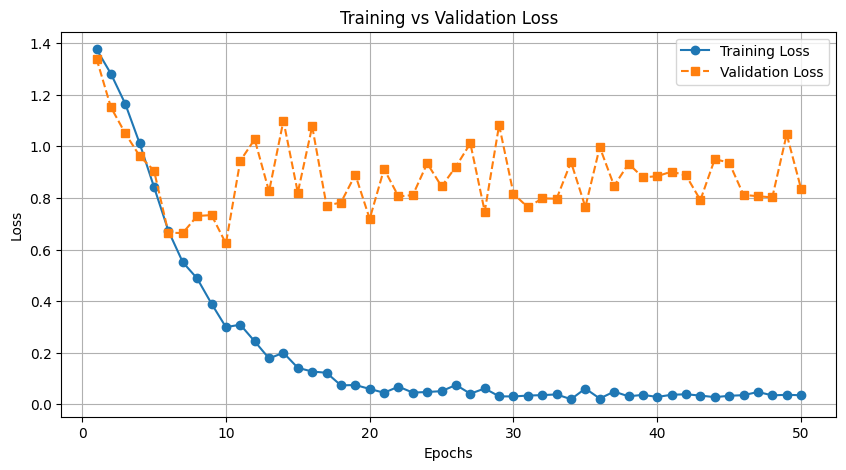

In [26]:
train_model(model, optimizer, criterion, train_dataloader, val_dataloader, config.num_epochs, device,config.num_classes, model_path="best_model1.pth", csv_name="training_results1.csv")

## Test Evaluation & Result Visualization

Here we evaluate the trained model on the held-out test set to estimate real-world performance. Metrics and visualizations such as confusion matrices and sample predictions are used to understand how well the model distinguishes between the different breast cancer subtypes.


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipython-input-324665692.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)


Confusion matrix saved to: confusion_matrix_test.png


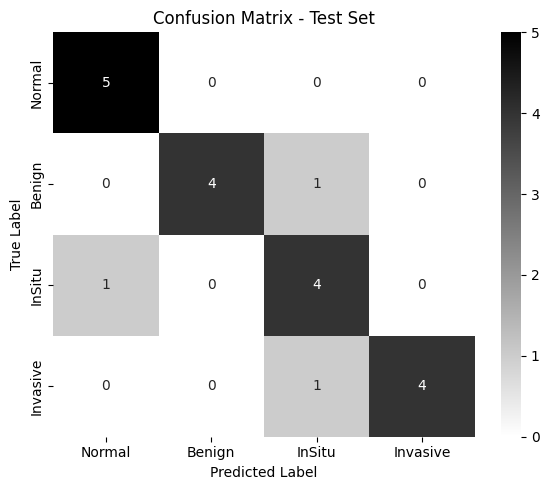


Inference Completed in 16.13s

Macro Precision: 0.8750, Macro Recall: 0.8500, Macro F1-score: 0.8535
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 1.0000, Recall: 0.8000, F1-score: 0.8889
Class 2 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 3 - Precision: 1.0000, Recall: 0.8000, F1-score: 0.8889


In [27]:
best_model_path = "./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/code/best_model1.pth"
inference_model(model, best_model_path, test_dataloader, device, config.num_classes)